In [1]:
# Import packages
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage
import numpy as np

C:\Users\User\AppData\Roaming\Python\Python311\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
c:\ProgramData\anaconda3\Lib\site-packages\transformers\utils\generic.py:482: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


## Prepare photos

In [2]:
import pickle
# Load images from the pickle file
with open('images.pkl', 'rb') as f:
    images = pickle.load(f)

In [9]:
# Separate positive from negative samples
has_bacteria = [images[i] for i in range(len(images)) if images[i]['info'][2] == '1']
no_bacteria = [images[i] for i in range(len(images)) if images[i]['info'][2] == '-1']
# Print the result
print(len(has_bacteria), len(no_bacteria))

1460 1048


## Autoencoder

In [30]:
# Define transformations
transform = transforms.Compose([    
    transforms.ToTensor(),  # Converts to tensor and scales to [0, 1] range
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1] range
])

# Custom dataset class
class PILImageDataset(Dataset):
    def __init__(self, images, transform=None):
        self.images = images
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]['img']
        if self.transform:
            img = self.transform(img)
        return img

# Create dataset and dataloader
cut = round(len(no_bacteria) * 0.8)

trainset = PILImageDataset(no_bacteria[:cut], transform=transform)
valset = PILImageDataset(no_bacteria[cut:], transform=transform)

trainloader = DataLoader(trainset, batch_size=32, shuffle=True) 
valoader = DataLoader(valset, batch_size=32, shuffle=False) 

In [31]:
%%capture
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        
        # Encoder
        self.enc_conv1 = nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1)   # 256x256 -> 128x128
        self.enc_relu1 = nn.ReLU(True)
        
        self.enc_conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)  # 128x128 -> 64x64
        self.enc_relu2 = nn.ReLU(True)
        
        self.enc_conv3 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1) # 64x64 -> 32x32
        self.enc_relu3 = nn.ReLU(True)
        
        self.enc_conv4 = nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1) # 32x32 -> 16x16
        self.enc_relu4 = nn.ReLU(True)
        
        # Decoder
        self.dec_conv1 = nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1) # 16x16 -> 32x32
        self.dec_relu1 = nn.ReLU(True)
        
        self.dec_conv2 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1) # 32x32 -> 64x64
        self.dec_relu2 = nn.ReLU(True)
        
        self.dec_conv3 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)  # 64x64 -> 128x128
        self.dec_relu3 = nn.ReLU(True)
        
        self.dec_conv4 = nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1)    # 128x128 -> 256x256
        self.dec_sigmoid = nn.Sigmoid()  # Use sigmoid for (0, 1) output range for normalized RGB

    def forward(self, x):
        # Encoder path with saved activations for skip connections
        x1 = self.enc_relu1(self.enc_conv1(x))
        x2 = self.enc_relu2(self.enc_conv2(x1))
        x3 = self.enc_relu3(self.enc_conv3(x2))
        x4 = self.enc_relu4(self.enc_conv4(x3))
        
        # Decoder path with skip connections
        x = self.dec_relu1(self.dec_conv1(x4) + x3)  # Skip connection from x3
        x = self.dec_relu2(self.dec_conv2(x)) # + x2)   # Skip connection from x2
        x = self.dec_relu3(self.dec_conv3(x)) # + x1)   # Skip connection from x1
        x = self.dec_sigmoid(self.dec_conv4(x))
    
        return x

# Example usage
model = ConvAutoencoder()

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

In [32]:
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
num_epochs = 10

# Training loop
for epoch in range(num_epochs):
    ii = 0
    for data in trainloader:  # Assuming `dataloader` provides (images) batches  
        ii+=1      
        img = data.to(device)
        
        # Forward pass
        output = model(img)
        loss = criterion(output, img)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # print(f'{ii}/{len(trainloader)} batches done!')
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Save model weights
torch.save(model.state_dict(), 'model_weights.pth')

Epoch [1/10], Loss: 0.0208
Epoch [2/10], Loss: 0.0138
Epoch [3/10], Loss: 0.0072
Epoch [4/10], Loss: 0.0088
Epoch [5/10], Loss: 0.0097
Epoch [6/10], Loss: 0.0063
Epoch [7/10], Loss: 0.0091
Epoch [8/10], Loss: 0.0099
Epoch [9/10], Loss: 0.0065
Epoch [10/10], Loss: 0.0091


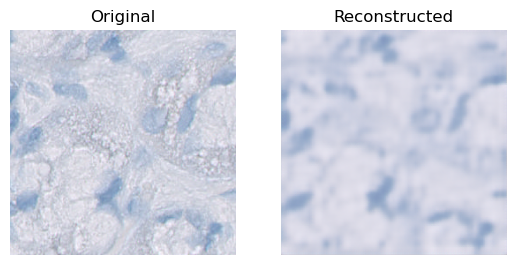

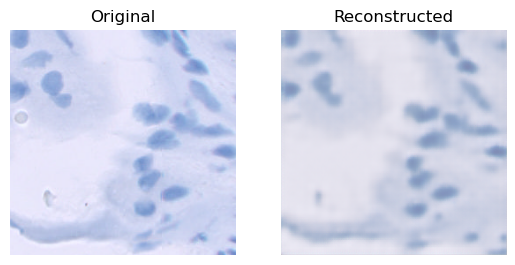

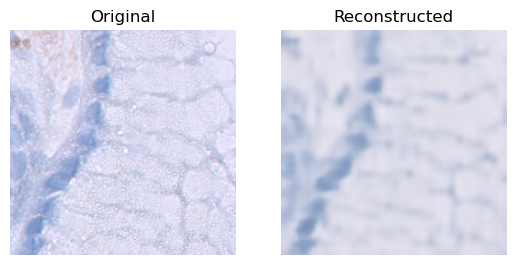

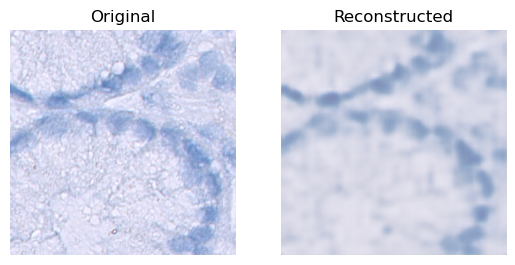

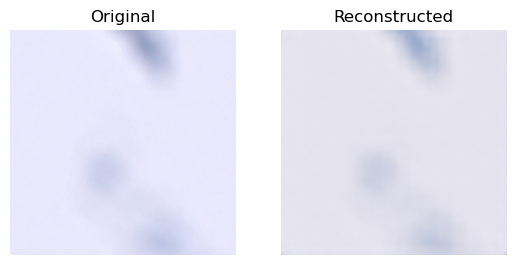

In [33]:
# Load the trained model (assuming model is already defined and loaded with weights)
# Uncomment the next line if you need to load model weights from a saved file
# model.load_state_dict(torch.load("path_to_model_weights.pth"))

# Set model to evaluation mode
model.eval()

# Move model to the same device as data (e.g., GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Function to perform inference and display the input and reconstructed images
def infer_and_display(dataloader, model, num_images=5):
    with torch.no_grad():  # Disable gradient computation for inference
        for batch in dataloader:
            batch = batch.to(device)
            
            # Pass the batch through the autoencoder
            reconstructed = model(batch)
            
            # Move data back to CPU for visualization
            batch = batch.cpu()
            reconstructed = reconstructed.cpu()
            
            # Display a few input and output images
            for i in range(min(num_images, len(batch))):
                original_img = ToPILImage()(batch[i] * 0.5 + 0.5)  # Unnormalize [-1, 1] -> [0, 1]
                reconstructed_img = ToPILImage()(reconstructed[i] * 0.5 + 0.5)
                
                # Plot the original and reconstructed images side by side
                fig, axes = plt.subplots(1, 2)
                axes[0].imshow(np.asarray(original_img))
                axes[0].set_title("Original")
                axes[0].axis("off")

                axes[1].imshow(np.asarray(reconstructed_img))
                axes[1].set_title("Reconstructed")
                axes[1].axis("off")

                plt.show()
            
            break  # Only display one batch; remove this to go through all batches

# Perform inference and display results
infer_and_display(trainloader, model, num_images=5)